# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk.tokenize as tokenize
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim

# Data

In [2]:
# Loading test and train sets
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
# test_data_labels has correct labels of test data (added after 
# competition). -1 means the comment wasn't  used in scoring, 
# which is why I later sort out all the -1s.
test_data_labels = pd.read_csv("data/test_labels.csv") 

In [3]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
test_data_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [6]:
# Adding labels to the test data and removing the rows with -1s.
test_data_processed = pd.merge(
    test_data, test_data_labels, on="id"
).drop("id", axis=1)
test_data_processed = test_data_processed[
    test_data_processed['toxic'] >= 0
].reset_index(drop=True) 
test_data_processed.tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
63973,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
63974,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
63975,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
63976,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0
63977,""" \n\n == Unicorn lair discovery == \n\n Suppo...",0,0,0,0,0,0


# Vocabulary

In [7]:
# MAX_LENGTH determines the maximum length of the comments
# (number of tokens). Longer comments are shortened, shorter 
# comments are padded. This ensures consisten input size.
MAX_LENGTH = 500
# Builds a vocabulary of the VOCAB_SIZE most common words.
# Vocabulary is a dictionary of the form {"word": index}
# where word is a token and index is a non-negative,
# unique number. This dictionary is used by the embedding
# layer in the gru later on.
VOCAB_SIZE = 5000
words = list()
for i in range(len(train_data)):
    words.extend(tokenize.word_tokenize(
        train_data["comment_text"][i].lower()
    ))
# We only consider the 5000 most common words.
common_words = [x[0] for x in Counter(words).most_common()[:VOCAB_SIZE]]
# <PAD> is used to pad short comments to MAX_LENGTH.
dictionary = {"<PAD>": 0}
for word in common_words:
    dictionary[word] = len(dictionary)

# Model

In [11]:
class GRU(nn.Module):
    """
    GRU model with an embedding layer (input), gru layer, 
    and linear layer (output). Uses randomly initialized
    embeddings of dimension 128.
    """
    def __init__(
        self, 
        batch_size, 
        input_dim=MAX_LENGTH, 
        vocab=dictionary, 
        num_layers=1, 
        embedding_dim=128, 
        hidden_dim=128, 
        output_dim=6
    ):
        super(GRU, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim
 
        self.embed = nn.Embedding(
            len(vocab)+1, 
            embedding_dim
        )
        self.gru = nn.GRU(
            embedding_dim, 
            hidden_dim, 
            num_layers
        ) 
        self.hidden = torch.zeros(
            num_layers, 
            batch_size, 
            hidden_dim
        )
        self.out = nn.Linear(
            self.hidden_dim*input_dim, 
            output_dim
        )
    
    def reset_state(self):
        """
        Turns hidden layer of gru back to all zeros. 
        This should be done whenever a new input is 
        fed into the network.
        """
        self.hidden = torch.zeros(
            self.num_layers, 
            self.batch_size, 
            self.hidden_dim
        )
    
    def forward(self, x):
        """
        Takes a one-dimensional tensor of length MAX_LENGTH
        and returns tensor of length output_dim.
        """
        x = self.embed(x)
        x, _ = self.gru(x)
        x = self.out(x[-1].view(1, -1))
        return x.view(self.output_dim)

In [12]:
# Define network, loss function, and optimizer
gru = GRU(batch_size=1)
# BCEWithLogitsLoss takes the output of a linear layer as 
# input and applies sigmoid function to it. That's why the 
# gru has a linear and not a sigmoid output layer. 
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.001)
# Huge dataset so only one epoch.
epochs = 1

# Training

In [13]:
# Training the model
torch.manual_seed(999)
all_y = train_data[train_data.columns[-6:]].values

# Looping over epochs
for epoch in range(epochs):
    
    # Looping over comments
    for i in range(int(len(train_data))):
        
        if i%10000==0:
            print(i/int(len(train_data)))
            
        # Tokenizing comment
        x = tokenize.word_tokenize(
            train_data["comment_text"][i].lower()
        )
        
        # Padding or cutting comment as necessary
        x = [x[i] if i<len(x) else "<PAD>" for i in range(MAX_LENGTH)]
        
        # Getting indecies for words and turning into tensor
        x = torch.LongTensor(
            [[dictionary.get(j, len(dictionary)) for j in x]]
        )
        
        # Getting true label and turning into tensor
        y = torch.FloatTensor(all_y[i])
        
        # Resetting state of gru cell
        gru.reset_state()
        
        # Predicting lables
        yHat = gru(x)
        
        # Calculating loss
        error = loss(yHat, y)
        
        # Resetting gradients and backpropagating
        optimizer.zero_grad()
        error.backward()
        optimizer.step()

0.0
0.0626680286518227
0.1253360573036454
0.1880040859554681
0.2506721146072908
0.3133401432591135
0.3760081719109362
0.4386762005627589
0.5013442292145815
0.5640122578664043
0.626680286518227
0.6893483151700497
0.7520163438218724
0.8146843724736951
0.8773524011255178
0.9400204297773405


# Test

In [14]:
# Predicting on test set
results = []
all_y_test = test_data_processed[
    test_data_processed.columns[-6:]
].values

# Looping over test data
for i in range(int(len(test_data_processed))):
    
    if i%2000==0:
        print(i/(len(test_data_processed)))
        
    # Tokenizing comment
    x = tokenize.word_tokenize(
        test_data_processed["comment_text"][i].lower()
    )
    
    # Padding or cutting comment as necessary
    x = [x[i] if i<len(x) else "<PAD>" for i in range(MAX_LENGTH)]
    
    # Getting indecies for words and turning into tensor
    x = torch.LongTensor(
        [[dictionary.get(j, len(dictionary)) for j in x]]
    ).detach()
    
    # Getting true label and turning into tensor
    y = torch.FloatTensor(all_y_test[i]).detach()
    
    # Resetting state of gru cell
    gru.reset_state()
    
    # Predicting lables
    yHat = gru(x)
    
    # Taking sigmoid of gru output and rounding it
    # to nearest integer (0 or 1). Remember that gru
    # output layer is linear since sigmoid is calculated
    # in loss. Now we have to calculate sigmoid manually.
    prediction = np.array(np.rint(
        torch.sigmoid(yHat).detach().numpy()
    ))
    
    # The resulting array should be interpreted as follows:
    # 0 = correct prediction (true label == predicted label)
    # -1 = False positive (true label = 0, predicted label = 1)
    # 1 = False negative (true label = 1, predicted label = 0)
    results.append(y.numpy()-prediction)

0.0
0.03126074588139673
0.06252149176279347
0.09378223764419019
0.12504298352558693
0.15630372940698364
0.18756447528838038
0.21882522116977712
0.25008596705117386
0.2813467129325706
0.3126074588139673
0.34386820469536405
0.37512895057676077
0.4063896964581575
0.43765044233955425
0.46891118822095096
0.5001719341023477
0.5314326799837444
0.5626934258651412
0.5939541717465379
0.6252149176279346
0.6564756635093313
0.6877364093907281
0.7189971552721248
0.7502579011535215
0.7815186470349182
0.812779392916315
0.8440401387977117
0.8753008846791085
0.9065616305605052
0.9378223764419019
0.9690831223232986


In [15]:
# Calculating statistic from results. "Label" refers
# to individual labels (six per comment) while "comment"
# refers to all six labels of a comment.

# Initializing stats at 0
comment_correct = 0
comment_incorrect = 0
one_off = 0
two_off = 0
three_off = 0
four_off = 0
five_off = 0
six_off = 0
label_correct = 0
label_incorrect = 0
false_positive = 0
false_negative = 0

# Looping over results
for r in results:
    
    # Adding label stats
    label_correct += sum(r==0)
    label_incorrect += sum(r!=0)
    false_positive += sum(r==-1)
    false_negative += sum(r==1)
    
    # Adding comment stats.
    # Comment only correct if all labels correct.
    if sum(r==0)==len(r):
        comment_correct += 1
    elif sum(r==0)==(len(r)-1):
        one_off += 1
        comment_incorrect += 1
    elif sum(r==0)==(len(r)-2):
        two_off += 1
        comment_incorrect += 1
    elif sum(r==0)==(len(r)-3):
        three_off += 1
        comment_incorrect += 1
    elif sum(r==0)==(len(r)-4):
        four_off += 1
        comment_incorrect += 1
    elif sum(r==0)==(len(r)-5):
        five_off += 1
        comment_incorrect += 1
    elif sum(r==0)==(len(r)-6):
        six_off += 1
        comment_incorrect += 1
    else:
        six_off += 1
        comment_incorrect += 1

# Results

In [16]:
def plot_results(labels, sizes, explode, title):
    fig1, ax1 = plt.subplots()
    ax1.pie(
        sizes, 
        explode=explode, 
        labels=labels, 
        autopct='%1.1f%%', 
        pctdistance=1.2, 
        labeldistance=1.4, 
        shadow=True, 
        startangle=0
    )
    ax1.axis('equal')
    plt.title(title)

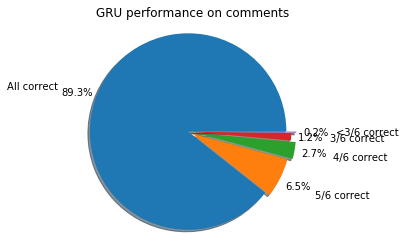

In [17]:
# Plotting results on comments
labels = 'All correct', '5/6 correct', '4/6 correct', '3/6 correct', '<3/6 correct'
sizes = [
    comment_correct, 
    one_off, 
    two_off, 
    three_off, 
    four_off + five_off + six_off
]
explode = (0., 0.05, 0.1, 0.05, 0.1)
plot_results(labels, sizes, explode, "GRU performance on comments")

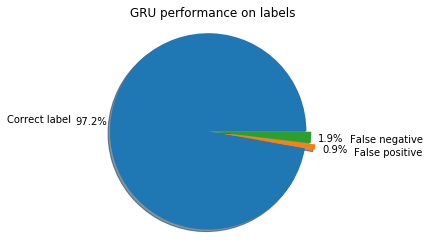

In [18]:
# Plotting results on labels
labels = 'Correct label', 'False positive', 'False negative'
sizes = [label_correct, false_positive, false_negative]
explode = (0., 0.1, 0.05)
plot_results(labels, sizes, explode, "GRU performance on labels")

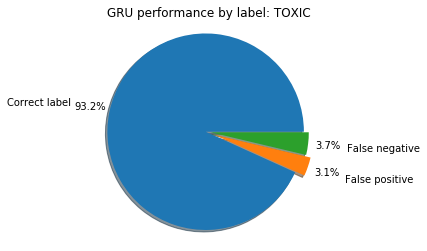

In [19]:
# Plotting results by label: TOXIC
label = np.array([r[0] for r in results])
labels = "Correct label", "False positive", "False negative"
sizes = [sum(label == 0), sum(label == -1), sum(label == 1)]
explode = (0., 0.1, 0.05)
plot_results(labels, sizes, explode, "GRU performance by label: TOXIC")

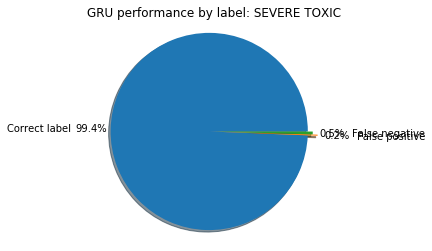

In [20]:
# Plotting results by label: SEVERE TOXIC
label = np.array([r[1] for r in results])
labels = "Correct label", "False positive", "False negative"
sizes = [sum(label == 0), sum(label == -1), sum(label == 1)]
explode = (0., 0.1, 0.05)
plot_results(labels, sizes, explode, "GRU performance by label: SEVERE TOXIC")

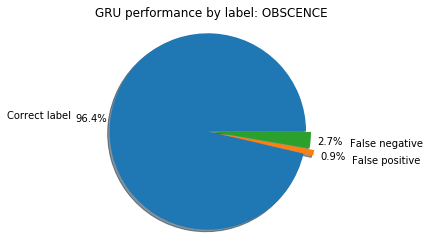

In [21]:
# Plotting results by label: OBSCENE
label = np.array([r[2] for r in results])
labels = "Correct label", "False positive", "False negative"
sizes = [sum(label == 0), sum(label == -1), sum(label == 1)]
explode = (0., 0.1, 0.05)
plot_results(labels, sizes, explode, "GRU performance by label: OBSCENCE")

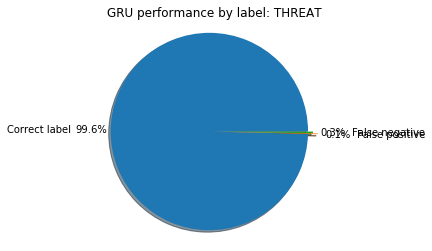

In [22]:
# Plotting results by label: THREAT
label = np.array([r[3] for r in results])
labels = "Correct label", "False positive", "False negative"
sizes = [sum(label == 0), sum(label == -1), sum(label == 1)]
explode = (0., 0.1, 0.05)
plot_results(labels, sizes, explode, "GRU performance by label: THREAT")

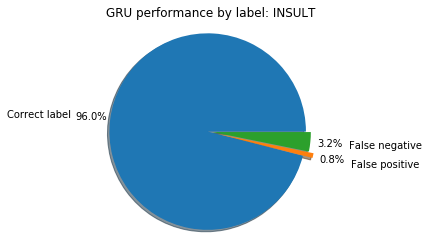

In [23]:
# Plotting results by label: INSULT
label = np.array([r[4] for r in results])
labels = "Correct label", "False positive", "False negative"
sizes = [sum(label == 0), sum(label == -1), sum(label == 1)]
explode = (0., 0.1, 0.05)
plot_results(labels, sizes, explode, "GRU performance by label: INSULT")

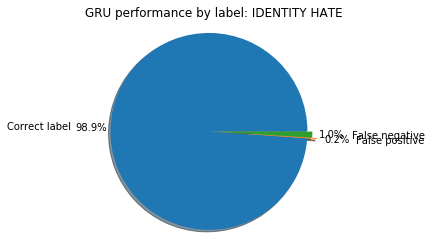

In [24]:
# Plotting results by label: IDENTITY HATE
label = np.array([r[5] for r in results])
labels = "Correct label", "False positive", "False negative"
sizes = [sum(label == 0), sum(label == -1), sum(label == 1)]
explode = (0., 0.1, 0.05)
plot_results(labels, sizes, explode, "GRU performance by label: IDENTITY HATE")

# Examples

In [25]:
def get_prediction(row):
    """
    Takes the index of a row in test_data_processed
    and returns a small dataframe with the results.
    Label is the true label, prediction is the
    predicted label.
    """
    z = test_data_processed["comment_text"][row]
    z = tokenize.word_tokenize(z.lower())
    z = [z[i] if i<len(z) else "<PAD>" for i in range(MAX_LENGTH)]
    z = torch.LongTensor([[dictionary.get(j, len(dictionary)) for j in z]])
    return pd.DataFrame({
        "class": np.array(["toxic", "severe_toxic", "obscene", "threat", "insult", "indentity_hate"]),
        "label": np.array(test_data_processed[test_data_processed.columns[-6:]].iloc[row]),
        "prediction": torch.sigmoid(gru(z)).detach().numpy()
    })

In [26]:
print(test_data_processed["comment_text"][24])
get_prediction(24)

DJ Robinson is gay as hell! he sucks his dick so much!!!!!


,class,label,prediction
0,toxic,1,0.999892
1,severe_toxic,0,0.038360
2,obscene,1,0.999637
3,threat,0,0.000199
4,insult,1,0.977315
5,indentity_hate,1,0.033754


In [27]:
print(test_data_processed["comment_text"][11])
get_prediction(11)

@RedSlash, cut it short. If you have sources stating the RoK is sovereign post them. Otherwise please aknowledge WP is not the place to make OR.


,class,label,prediction
0,toxic,0,0.013604
1,severe_toxic,0,0.000477
2,obscene,0,0.001170
3,threat,0,0.000138
4,insult,0,0.013752
5,indentity_hate,0,0.001520


In [28]:
print(test_data_processed["comment_text"][22666])
get_prediction(22666)

" 
 :RLH I have been trying my best to remain as nice as possible with Schrocat but it gets real hard when he keeps telling me and others to fuck off all the time. But I appreciate your interest in resolving the Peter Sellers issues.   "


,class,label,prediction
0,toxic,0,0.687056
1,severe_toxic,0,0.000214
2,obscene,0,0.035306
3,threat,0,0.000027
4,insult,0,0.099518
5,indentity_hate,0,0.000577


In [29]:
print(test_data_processed["comment_text"][342])
get_prediction(342)

you fucking braindead oroszka 50% of the syrian government is sunni including the first lady and the army.


,class,label,prediction
0,toxic,1,0.958750
1,severe_toxic,0,0.034496
2,obscene,1,0.828052
3,threat,0,0.000270
4,insult,1,0.517642
5,indentity_hate,0,0.004500


In [30]:
print(test_data_processed["comment_text"][919])
get_prediction(919)

who is DJMASACRE? 

 what the heck is a sockpuppet ?  If this is what happens on wikipedia then this is really pathetic.  So much for finding information here, its just filled with garbage.  (


,class,label,prediction
0,toxic,1,0.369368
1,severe_toxic,0,0.001431
2,obscene,0,0.004219
3,threat,0,0.000083
4,insult,0,0.022581
5,indentity_hate,0,0.001471
